In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
import pickle
from shutil import copyfile
from mpl_toolkits.axes_grid1 import ImageGrid
import bigbadbrain as bbb

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load premotor center

In [204]:
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/20230706_premotorcenter.nii"
pre_motor_center = ants.image_read(file)
#pre_motor_center = pre_motor_center[:,:,::-1]
pre_motor_center = ants.from_numpy(pre_motor_center.numpy()[:,:,::-1])
pre_motor_center.set_spacing((0.65,0.65,1))
ants.set_direction(pre_motor_center,np.eye(3))
#pre_motor_center

In [4]:
#pre_motor_center[pre_motor_center==0] = np.nan

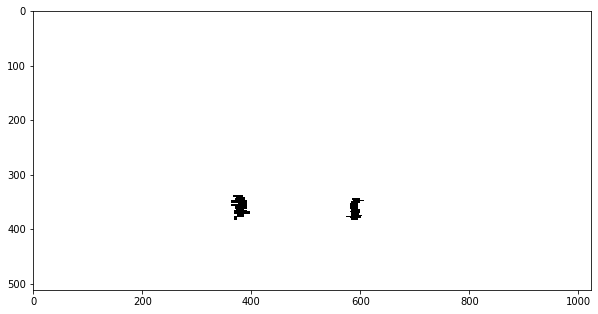

In [5]:
# plt.figure(figsize=(10,10))
# plt.imshow(pre_motor_center[:,:,160].T,cmap='gray')

# Load FDA/atlas

In [6]:
file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/luke.nii"
atlas = ants.image_read(file)
atlas.set_spacing((0.65,0.65,1))
ants.set_direction(atlas,np.eye(3))
atlas

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1024, 512, 256)
	 Spacing    : (0.65, 0.65, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

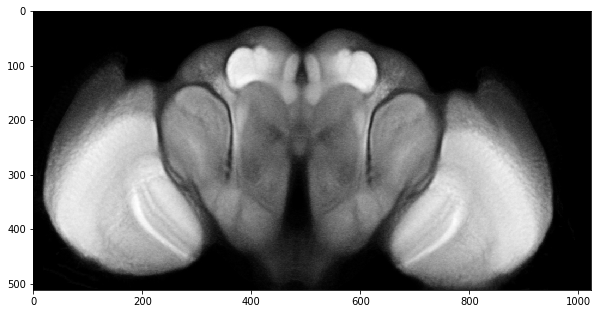

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(atlas[:,:,160].T,cmap='gray')

# Load individual fly IPS anat

In [291]:
#########
fly = 316
#########

In [292]:
dir_ = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}'

xml_file = os.path.join(dir_,'func_0','imaging','functional.xml')
dim_x, dim_y, dim_z = bbb.get_resolution(xml_file)

brain_file = os.path.join(dir_,'func_0','moco','functional_channel_1_moc_mean.nii')
anat = ants.image_read(brain_file)
anat.set_spacing((dim_x,dim_y,dim_z))
# anat_76 = ants.resample_image(anat,(.65,.65,1),use_voxels=False)
ants.set_direction(anat,np.eye(3))

sub_dim = {'x':anat.shape[0],
           'y':anat.shape[1],
           'z':anat.shape[2]}

sub_mids = {'x': int(anat.shape[0]/2),
            'y': int(anat.shape[1]/2),
            'z': int(anat.shape[2]/2)}

atlas_fly_res = ants.resample_image(atlas,(dim_x,dim_y,dim_z), use_voxels=False)
pmc_fly_res = ants.resample_image(pre_motor_center,(dim_x,dim_y,dim_z), use_voxels=False)

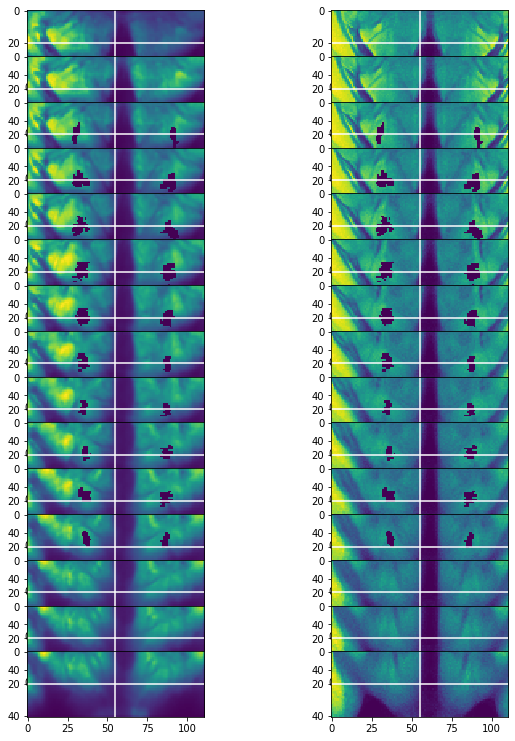

In [298]:
bbox = {'x':60,'y':70,'z':25} #316
#bbox = {'x':66,'y':70,'z':20} #317
#bbox = {'x':56,'y':80,'z':35} #327
#bbox = {'x':60,'y':80,'z':32} #328
#bbox = {'x':53,'y':80,'z':32} #329
#bbox = {'x':53,'y':70,'z':34} #330
#bbox = {'x':53,'y':80,'z':34} #337
#bbox = {'x':55,'y':80,'z':36} #338
#bbox = {'x':58,'y':80,'z':35} #339
###################################

atlas_crop = atlas_fly_res[bbox['x']:bbox['x']+sub_dim['x'],
               bbox['y']:bbox['y']+sub_dim['y'],
               bbox['z']:bbox['z']+sub_dim['z']]
atlas_crop = ants.from_numpy(atlas_crop)
atlas_crop.set_spacing((dim_x,dim_y,dim_z))
ants.set_direction(atlas_crop,np.eye(3))

pmc_crop = pmc_fly_res[bbox['x']:bbox['x']+sub_dim['x'],
               bbox['y']:bbox['y']+sub_dim['y'],
               bbox['z']:bbox['z']+sub_dim['z']]

mask = pmc_crop.copy()
mask[mask==0] = np.nan

plt.figure(figsize=(10,13))

for z in range(sub_dim['z']):
    
    plt.subplot(sub_dim['z'],2,z*2+1)
    plt.imshow(anat[:,:,z].T)
    plt.imshow(mask[:,:,z].T)
    plt.axvline(sub_mids['x'],color='w')
    plt.axhline(sub_mids['y'],color='w')
    
    plt.subplot(sub_dim['z'],2,z*2+2)
    plt.imshow(atlas_crop[:,:,z].T)
    plt.imshow(mask[:,:,z].T)
    plt.axvline(sub_mids['x'],color='w')
    plt.axhline(sub_mids['y'],color='w')

plt.subplots_adjust(hspace=-.3)

In [300]:
### save PMC
save_file = os.path.join(dir_,'warp')
if not os.path.isdir(save_file):
    os.mkdir(save_file)
save_file = os.path.join(save_file,'PMC_in_func')
np.save(save_file,pmc_crop)    


In [213]:
os.path.isdir(dir_)

True

In [146]:
from sklearn.preprocessing import quantile_transform
from skimage.exposure import equalize_adapthist

In [159]:
temp = anat.numpy().copy()
temp -= temp.min()
temp /= temp.max()
anat_cleaned = equalize_adapthist(temp[:,:,5],
                                  kernel_size=(20,20,20),
                                  clip_limit=.1)

In [160]:
temp -= temp.min()
temp /= temp.max()

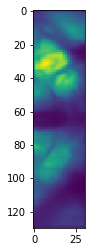

In [161]:
plt.imshow(temp[:,:,5])

In [186]:
temp.shape

(130, 31, 11)

In [190]:
anat_cleaned = equalize_adapthist(temp[:,:,5],
                                  kernel_size=(20,20,20),
                                  clip_limit=.1)

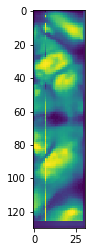

In [188]:
plt.imshow(anat_cleaned)

In [135]:
### Perform quantile normalization ###
anat_cleaned = quantile_transform(anat.flatten().reshape(-1, 1), n_quantiles=500, random_state=0, copy=True)
anat_cleaned = anat_cleaned.reshape((sub_dim['x'], sub_dim['y'], sub_dim['z']))
np.nan_to_num(anat_cleaned, copy=False);

anat_cleaned = ants.from_numpy(anat_cleaned)
anat_cleaned.set_spacing((dim_x,dim_y,dim_z))
ants.set_direction(anat_cleaned,np.eye(3))

(array([10599., 10276.,  7480.,  5763.,  4524.,  2676.,  1301.,   979.,
          613.,   119.]),
 array([  98.330795,  667.5374  , 1236.744   , 1805.9507  , 2375.1572  ,
        2944.3638  , 3513.5706  , 4082.777   , 4651.984   , 5221.1904  ,
        5790.397   ], dtype=float32),
 <a list of 10 Patch objects>)

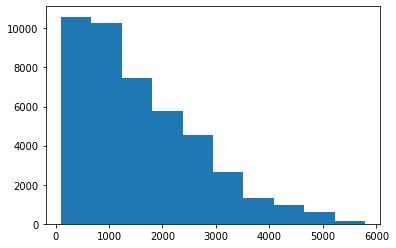

In [138]:
plt.hist(anat.flatten())

In [195]:
temp = anat.numpy().copy()
temp -= temp.min()
temp /= temp.max()
anat_cleaned = np.zeros((sub_dim['x'], sub_dim['y'], sub_dim['z']))
for z in range(sub_dim['z']):
    anat_cleaned[:,:,z] = equalize_adapthist(temp[:,:,z],
                                      kernel_size=(40,40,40),
                                      clip_limit=.5)
anat_cleaned = ants.from_numpy(anat_cleaned)
anat_cleaned.set_spacing((dim_x,dim_y,dim_z))
ants.set_direction(anat_cleaned,np.eye(3))

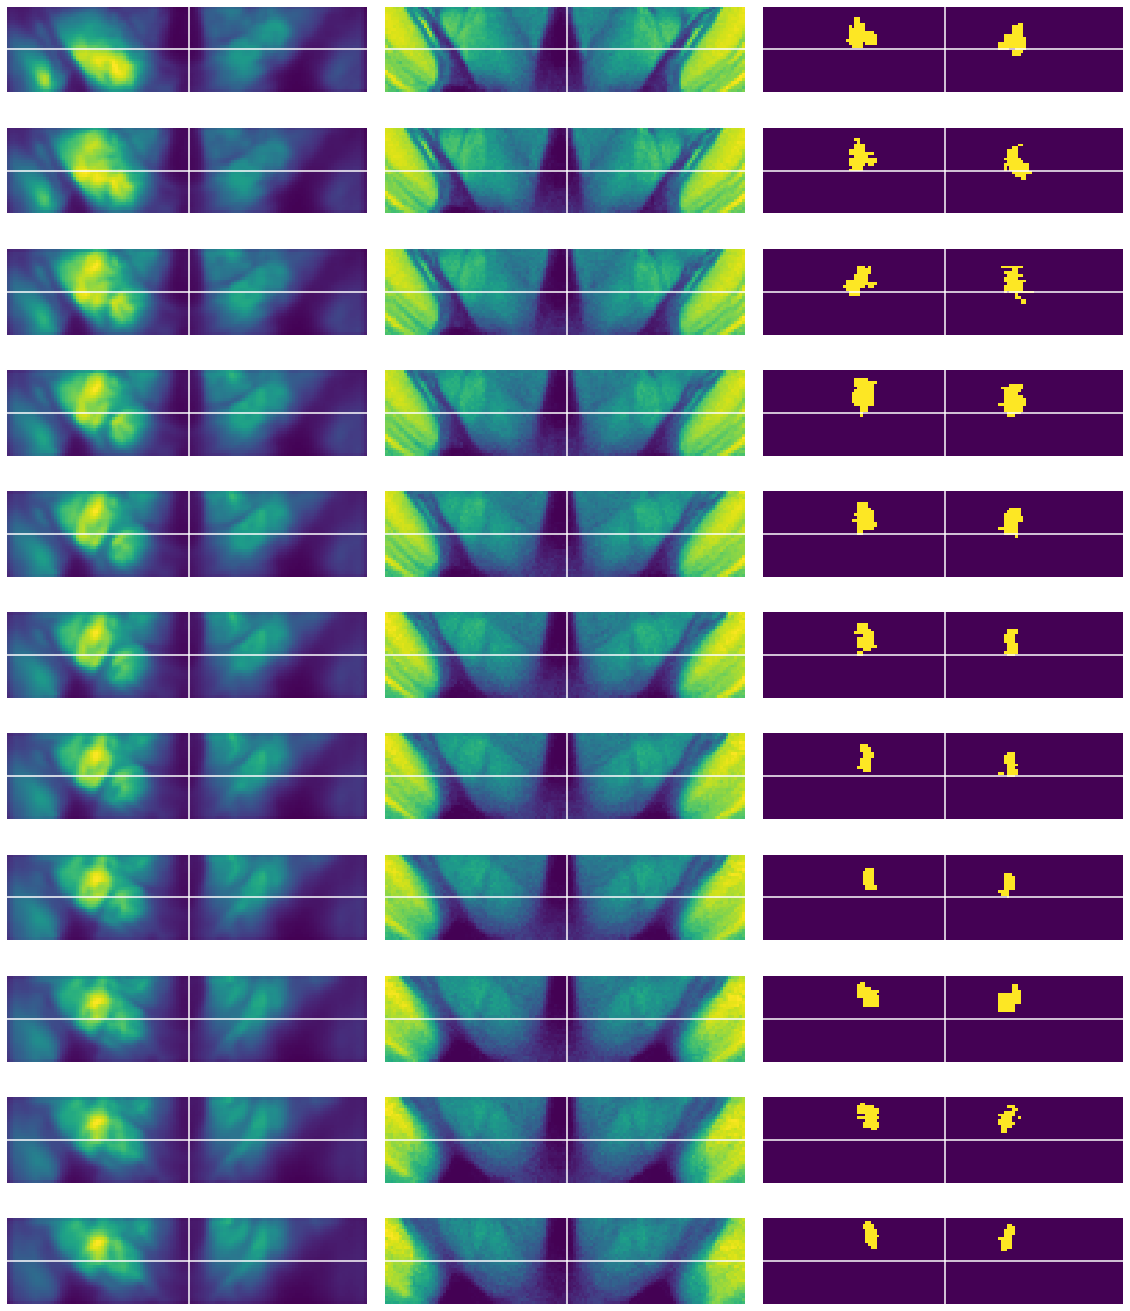

In [200]:
bbox = {'x':58,'y':80,'z':35} #339

#######################################

atlas_crop = atlas_fly_res[bbox['x']:bbox['x']+sub_dim['x'],
               bbox['y']:bbox['y']+sub_dim['y'],
               bbox['z']:bbox['z']+sub_dim['z']]
atlas_crop = ants.from_numpy(atlas_crop)
atlas_crop.set_spacing((dim_x,dim_y,dim_z))
ants.set_direction(atlas_crop,np.eye(3))

FDA_2_IPS = ants.registration(fixed = anat,
                  moving = atlas_crop,
                  type_of_transform = 'SyN')
                  #aff_metric='mattes',
                  #aff_sampling=100,
                  #aff_iterations=(2100,1200,1200,10))

pmc_crop = pmc_fly_res[bbox['x']:bbox['x']+sub_dim['x'],
               bbox['y']:bbox['y']+sub_dim['y'],
               bbox['z']:bbox['z']+sub_dim['z']]

plt.figure(figsize=(20,26))

for z in range(sub_dim['z']):
    
    plt.subplot(sub_dim['z'],3,z*3+1)
    plt.imshow(anat[:,:,z].T)
    plt.axvline(sub_mids['x'],color='w')
    plt.axhline(sub_mids['y'],color='w')
    plt.axis('off')
    
    plt.subplot(sub_dim['z'],3,z*3+2)
    plt.imshow(atlas_crop[:,:,z].T)
    plt.axvline(sub_mids['x'],color='w')
    plt.axhline(sub_mids['y'],color='w')
    plt.axis('off')
    
    plt.subplot(sub_dim['z'],3,z*3+3)
    plt.imshow(pmc_crop[:,:,z].T)
    plt.axvline(sub_mids['x'],color='w')
    plt.axhline(sub_mids['y'],color='w')
    plt.axis('off')
    
    #plt.subplot(sub_dim['z'],3,z*3+3)
    #plt.imshow(pmc_crop[:,:,z].T)

#     plt.imshow(atlas_crop[:,:,sub_mids['z']].T)
#     plt.axvline(sub_mids['x'],color='w')
#     plt.axhline(sub_mids['y'],color='w')
    #plt.imshow(pre_motor_center_crop[:,:,sub_mids['z']].T)
plt.subplots_adjust(hspace=-.4,wspace=.05)

In [ ]:
FDA_2_IPS = ants.registration(fixed = anat,
                  moving = atlas_crop,
                  type_of_transform = 'Affine')

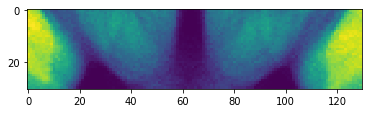

In [117]:
plt.imshow(atlas_crop[:,:,-1].T)

In [81]:
FDA_2_IPS = ants.registration(fixed = anat,
                  moving = atlas_crop,
                  type_of_transform = 'SyN')

In [83]:
FDA_2_IPS['warpedmovout']

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (130, 31, 11)
	 Spacing    : (2.6112, 2.6112, 4.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

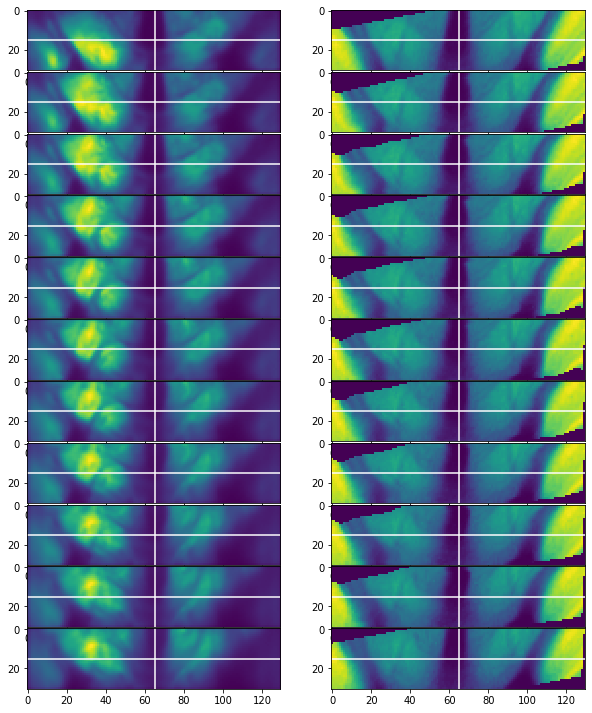

In [84]:
plt.figure(figsize=(10,13))

for z in range(sub_dim['z']):
    
    plt.subplot(sub_dim['z'],2,z*2+1)
    plt.imshow(anat[:,:,z].T)
    plt.axvline(sub_mids['x'],color='w')
    plt.axhline(sub_mids['y'],color='w')
    
    plt.subplot(sub_dim['z'],2,z*2+2)
    plt.imshow(FDA_2_IPS['warpedmovout'][:,:,z].T)
    plt.axvline(sub_mids['x'],color='w')
    plt.axhline(sub_mids['y'],color='w')
    
    #plt.subplot(sub_dim['z'],3,z*3+3)
    #plt.imshow(pmc_crop[:,:,z].T)


#     atlas_crop = atlas[center['x']-sub_mids['x']:center['x']+sub_mids['x'],
#                        center['y']-sub_mids['y']:center['y']+sub_mids['y'],
#                        center['z']-sub_mids['z']:center['z']+sub_mids['z']]
#     pre_motor_center_crop = pre_motor_center[center['x']-sub_mids['x']:center['x']+sub_mids['x'],
#                        center['y']-sub_mids['y']:center['y']+sub_mids['y'],
#                        center['z']-sub_mids['z']:center['z']+sub_mids['z']]

#     plt.imshow(atlas_crop[:,:,sub_mids['z']].T)
#     plt.axvline(sub_mids['x'],color='w')
#     plt.axhline(sub_mids['y'],color='w')
    #plt.imshow(pre_motor_center_crop[:,:,sub_mids['z']].T)
plt.subplots_adjust(hspace=-.3)

In [22]:
sub_dim = {'x':anat_76.shape[0],
           'y':anat_76.shape[1],
           'z':anat_76.shape[2]}
sub_mids = {'x': int(anat_76.shape[0]/2),
            'y': int(anat_76.shape[1]/2),
            'z': int(anat_76.shape[2]/2)}

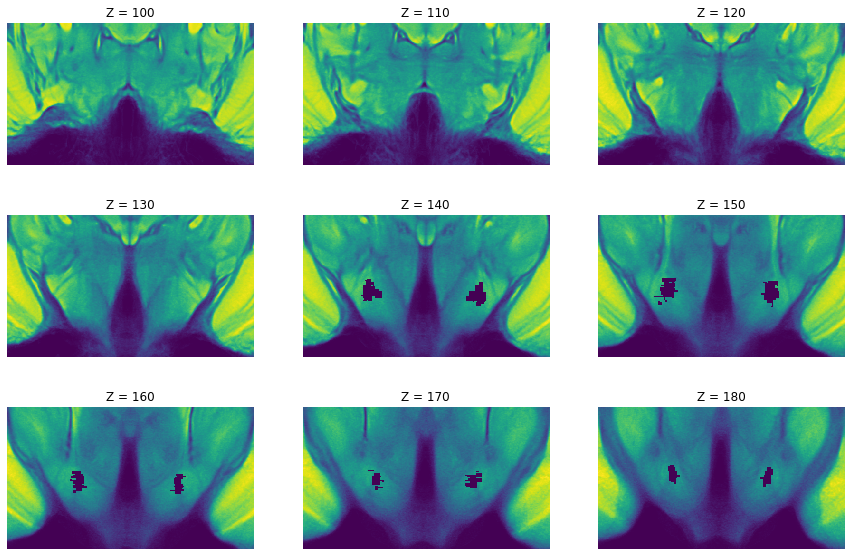

In [12]:
### plot a few z-planes to help visually pick the best
plt.figure(figsize=(15,10))
for i,z in enumerate([100,110,120,130,140,150,160,170,180]):
    plt.subplot(3,3,i+1)
    plt.imshow(atlas[230:750,200:500,z].T)
    plt.imshow(pre_motor_center[230:750,200:500,z].T)
    plt.title(F'Z = {z}')
    plt.axis('off')

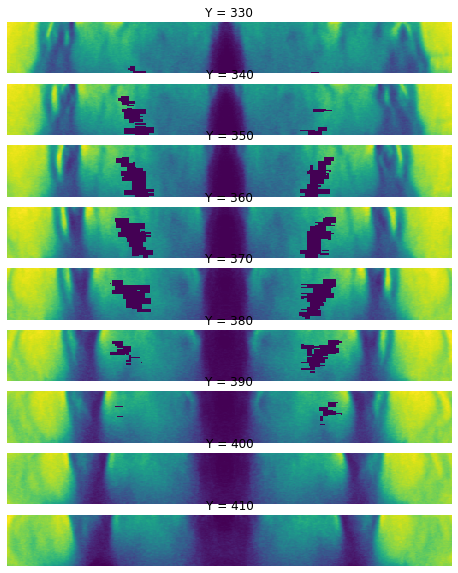

In [67]:
### plot a few z-planes to help visually pick the best
plt.figure(figsize=(15,10))
for i,y in enumerate(np.arange(330,420,10)):
    plt.subplot(9,1,i+1)
    plt.imshow(atlas[230:750,y,120:180].T)
    plt.imshow(pre_motor_center[230:750,y,120:180].T)
    plt.title(F'Y = {y}')
    plt.axis('off')

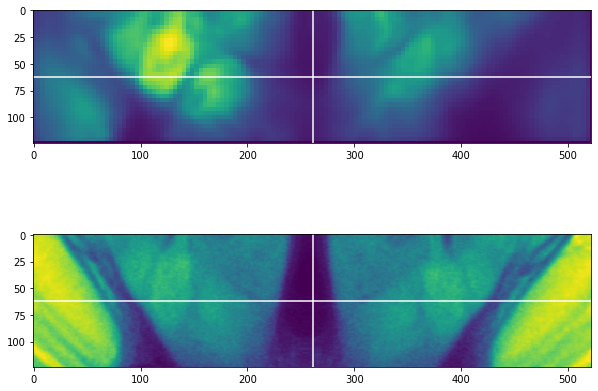

In [24]:
#######################################
#center = {'x':470,'y':400,'z':130} #315
#center = {'x':470,'y':380,'z':110} #316 # too shallow, maybe picked up a bit of pmc
#center = {'x':470,'y':400,'z':130} #317 ### this one is good depth, but needs tweaking; bad alignment
center = {'x':490,'y':370,'z':155} #339
#######################################

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(anat_76[:,:,sub_mids['z']].T)
plt.axvline(sub_mids['x'],color='w')
plt.axhline(sub_mids['y'],color='w')

atlas_crop = atlas[center['x']-sub_mids['x']:center['x']+sub_mids['x'],
                   center['y']-sub_mids['y']:center['y']+sub_mids['y'],
                   center['z']-sub_mids['z']:center['z']+sub_mids['z']]
pre_motor_center_crop = pre_motor_center[center['x']-sub_mids['x']:center['x']+sub_mids['x'],
                   center['y']-sub_mids['y']:center['y']+sub_mids['y'],
                   center['z']-sub_mids['z']:center['z']+sub_mids['z']]

plt.subplot(212)
plt.imshow(atlas_crop[:,:,sub_mids['z']].T)
plt.axvline(sub_mids['x'],color='w')
plt.axhline(sub_mids['y'],color='w')
#plt.imshow(pre_motor_center_crop[:,:,sub_mids['z']].T)
plt.subplots_adjust(hspace=-.3)

In [26]:
anat_76.shape

(522, 125, 44)

In [ ]:
1,3,5,7



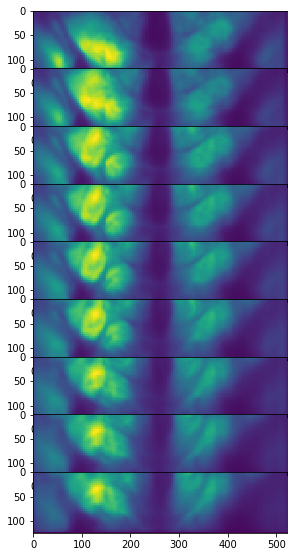

In [30]:
#######################################
#center = {'x':470,'y':400,'z':130} #315
#center = {'x':470,'y':380,'z':110} #316 # too shallow, maybe picked up a bit of pmc
#center = {'x':470,'y':400,'z':130} #317 ### this one is good depth, but needs tweaking; bad alignment
center = {'x':490,'y':370,'z':155} #339
#######################################

plt.figure(figsize=(10,10))

for i,z in enumerate(np.arange(0,45,5)):
    plt.subplot(9,2,i*2+1)

    plt.imshow(anat_76[:,:,z].T)
    #plt.axvline(sub_mids['x'],color='w')
    #plt.axhline(sub_mids['y'],color='w')

#     atlas_crop = atlas[center['x']-sub_mids['x']:center['x']+sub_mids['x'],
#                        center['y']-sub_mids['y']:center['y']+sub_mids['y'],
#                        center['z']-sub_mids['z']:center['z']+sub_mids['z']]
#     pre_motor_center_crop = pre_motor_center[center['x']-sub_mids['x']:center['x']+sub_mids['x'],
#                        center['y']-sub_mids['y']:center['y']+sub_mids['y'],
#                        center['z']-sub_mids['z']:center['z']+sub_mids['z']]

#     plt.imshow(atlas_crop[:,:,sub_mids['z']].T)
#     plt.axvline(sub_mids['x'],color='w')
#     plt.axhline(sub_mids['y'],color='w')
    #plt.imshow(pre_motor_center_crop[:,:,sub_mids['z']].T)
plt.subplots_adjust(hspace=-.3)

In [39]:
atlas_crop = ants.from_numpy(atlas_crop)
atlas_crop.set_spacing((0.65,0.65,1))
atlas_crop.shape

(522, 124, 44)

# align

In [40]:
IPS_2_FDA = ants.registration(fixed = atlas_crop,
                  moving = anat_76,
                  type_of_transform = 'SyN')

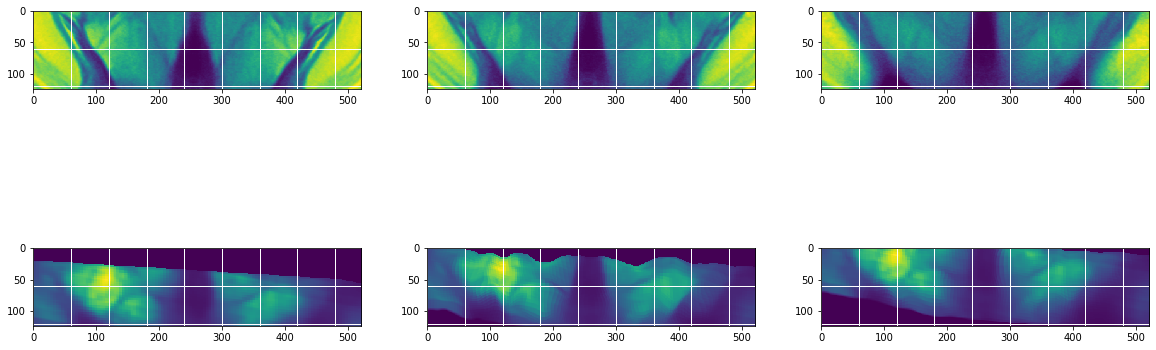

In [47]:
def draw_grid(vlines=9, hlines=3, step=60, lw=1):
    for i in np.arange(0,vlines*step,step):
        plt.axvline(i,color='w',lw=lw)
    for i in np.arange(0,hlines*step,step):
        plt.axhline(i,color='w',lw=lw)
    
plt.figure(figsize=(20,8))
for i,k in enumerate([0,20,40]):
    plt.subplot(2,3,i+1)
    plt.imshow(atlas_crop.numpy()[:,:,k].T)
    draw_grid()
    plt.subplot(2,3,i+1+3)
    plt.imshow(IPS_2_FDA['warpedmovout'][:,:,k].T)
    draw_grid()

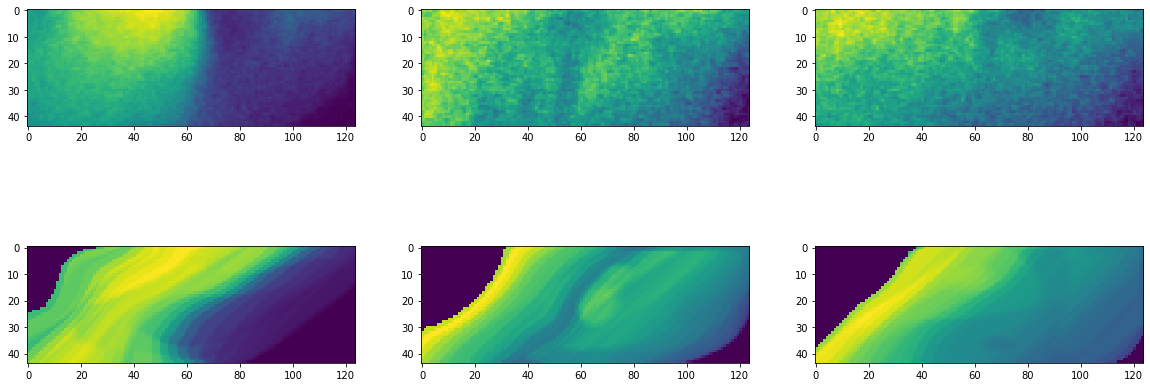

In [49]:
def draw_grid(vlines=8, hlines=4, step=20, lw=1):
    for i in np.arange(0,vlines*step,step):
        plt.axvline(i,color='w',lw=lw)
    for i in np.arange(0,hlines*step,step):
        plt.axhline(i,color='w',lw=lw)
    
plt.figure(figsize=(20,8))
for i,k in enumerate([100,200,300]):
    plt.subplot(2,3,i+1)
    plt.imshow(atlas_crop.numpy()[k,:,:].T)
    plt.imshow(pre_motor_center_crop[k,:,:].T)
    #draw_grid()
    plt.subplot(2,3,i+1+3)
    plt.imshow(IPS_2_FDA['warpedmovout'][k,:,:].T)
    #draw_grid()

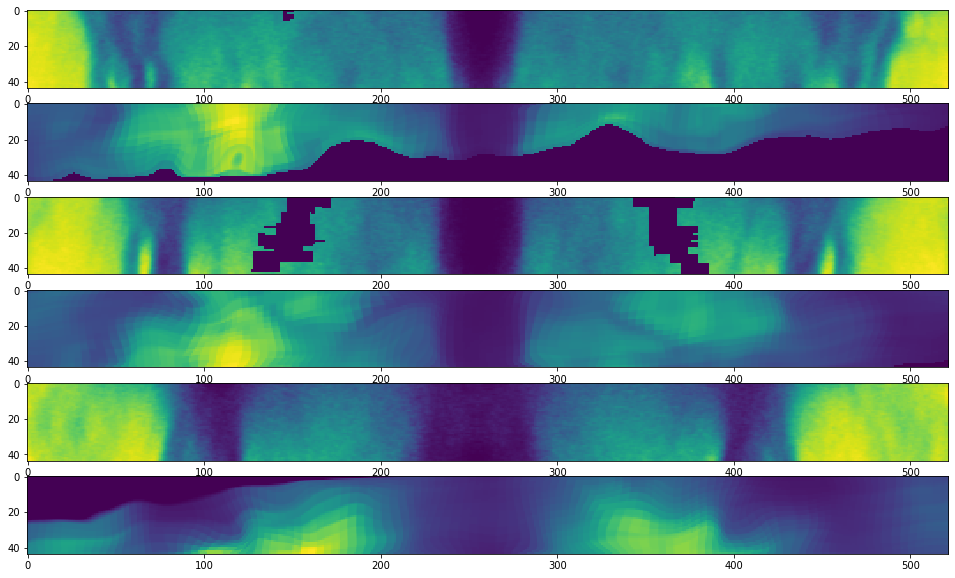

In [50]:
def draw_grid(vlines=15, hlines=3, step=30, lw=1):
    for i in np.arange(0,vlines*step,step):
        plt.axvline(i,color='w',lw=lw)
    for i in np.arange(0,hlines*step,step):
        plt.axhline(i,color='w',lw=lw)

plt.figure(figsize=(20,10))
for i,k in enumerate([20,50,100]): #0,1,2
    plt.subplot(6,1,(i*2)+1) #1,3,5
    plt.imshow(atlas_crop.numpy()[:,k,::-1].T)
    plt.imshow(pre_motor_center_crop[:,k,::-1].T)
    #draw_grid()
    plt.subplot(6,1,(i*2)+2) #2,4,6
    plt.imshow(IPS_2_FDA['warpedmovout'][:,k,::-1].T)
    #draw_grid()
#plt.subplots_adjust(hspace=-.8)

In [51]:
empty = np.zeros(atlas.shape)
empty[center['x']-sub_mids['x']:center['x']+sub_mids['x'],
      center['y']-sub_mids['y']:center['y']+sub_mids['y'],
      center['z']-sub_mids['z']:center['z']+sub_mids['z']] = IPS_2_FDA['warpedmovout'].numpy()

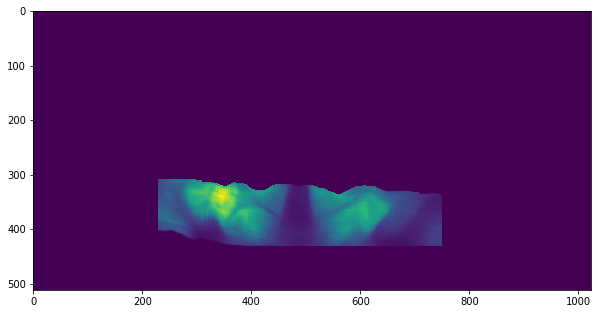

In [52]:
plt.figure(figsize=(10,10))
plt.imshow(empty[:,:,center['z']].T)

In [398]:
empty.shape

(1024, 512, 256)

In [432]:
empty = ants.from_numpy(empty[:,:,::-1])
empty.set_spacing((.65,.65,1))
empty_lowres =  ants.resample_image(empty,(4,4,4),use_voxels=False)

In [433]:
### save this to use fiji to better visualize
IPS_dir = "/oak/stanford/groups/trc/data/Brezovec/20230806_IPS"

save_file = os.path.join(IPS_dir, F'{fly}_in_luke_OG_low_res.nii')
nib.Nifti1Image(empty_lowres.numpy(), np.eye(4)).to_filename(save_file)

# Load OG corrs

In [123]:
# ### Load Luke Mean ###

# luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
# res_luke_mean = (0.65,0.65,1)
# luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
# luke_mean = luke_mean[:,:,::-1] #flipz
# luke_mean = ants.from_numpy(luke_mean)
# luke_mean.set_spacing(res_luke_mean)
# luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

In [21]:
# ### Load JFRC2018 ###

# fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
# res_JRC2018 = (0.38, 0.38, 0.38)
# fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
# fixed = ants.from_numpy(fixed)
# fixed.set_spacing(res_JRC2018)
# fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)

In [283]:
import bigbadbrain as bbb

In [310]:
################################
### Load voxel-res corr data ###
################################

dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210420_correlation/"
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
maps = {}
for behavior in behaviors:
    print(1)
    rvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'rvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(rvalues_to_load)

    pvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'pvalues_{}'.format(behavior) in x]
    bbb.sort_nicely(pvalues_to_load)
    
    r_map = []
    p_map = []
    for z in range(49):
        r_map.append(np.load(rvalues_to_load[z]))
        p_map.append(np.load(pvalues_to_load[z]))

    r_map = np.asarray(r_map)
    p_map = np.asarray(p_map)
    
    r_map = np.reshape(r_map, (49,256,128))
    p_map = np.reshape(p_map, (49,256,128))
    
    #r_map[p_map >= 1e-4]=0
    
    maps[behavior] = r_map
    
############################################
### Put into plotting format with colors ###
############################################

slices = []
for z in range(49):
    colors1 = maps['Z_neg'][z,:,:].T
    colors2 = maps['Z_pos'][z,:,:].T
    colors3 = maps['Y_pos'][z,:,:].T
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)
slices = np.asarray(slices)

func = np.swapaxes(slices, 0, 2)
func.shape


OG_corr = ants.from_numpy(func)
#moving.set_spacing((2.6076, 2.6154, 5.3125, 1)) ### matching this to the slightly off luke mean
#out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')
#maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0], imagetype=3, interpolator='nearestNeighbor')
#maps_voxel_res.shape

1
1
1


In [311]:
OG_corr = OG_corr.resample_image((1024,512,256,3),use_voxels=True)
OG_corr.set_spacing((.65,.65,1,1))

In [312]:
OG_corr

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (1024, 512, 256, 3)
	 Spacing    : (0.65, 0.65, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

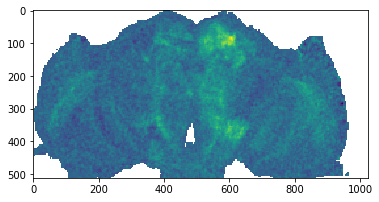

In [319]:
plt.imshow(OG_corr[:,:,140,0].T)

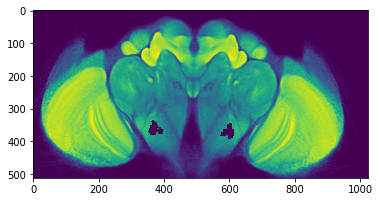

In [322]:
plt.imshow(atlas[:,:,140].T)
plt.imshow(pre_motor_center[:,:,140].T)

# Calculate corrs of IPS subvol

In [401]:
fly

317

In [412]:
func = 'func_0'
load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}/imaging'
brain_file = os.path.join(load_directory, 'functional_channel_2.nii')
brain = ants.image_read(brain_file).numpy()
print(brain.shape)
load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}'

(111, 41, 15, 13600)


In [50]:
# func = 'func_0'
# load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}'
# brain_file = os.path.join(load_directory, 'functional_channel_2_moco_zscore.h5')
# with h5py.File(brain_file, 'r') as hf:
#     brain = hf['data'][:]
# print(brain.shape)
# load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}'

(111, 41, 15, 13600)


In [34]:
# func = 'func_0'
# load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}/moco'
# brain_file = os.path.join(load_directory, 'functional_channel_2_moco.h5')
# with h5py.File(brain_file, 'r') as hf:
#     brain = hf['data'][:]
# print(brain.shape)
# load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}/{func}'

(111, 41, 15, 13600)


In [413]:
timestamps = brainsss.load_timestamps(os.path.join(load_directory, 'imaging'))
fictrac_raw = brainsss.load_fictrac(os.path.join(load_directory, 'fictrac'))

Trying to load timestamp data from hdf5 file.
Success.


In [414]:
resolution = 10 #desired resolution in ms
fps = 100
expt_len = fictrac_raw.shape[0]/fps*1000
fictrac_raw.shape

behaviors = ['dRotLabZneg', 'dRotLabZpos', 'dRotLabY', 'dRotLabZ']
fictrac = {}
z=7
for behavior,short in zip(behaviors,['R','L','F','Turn']):
    fictrac_interp = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps=timestamps, z=z)
    fictrac[short] = fictrac_interp

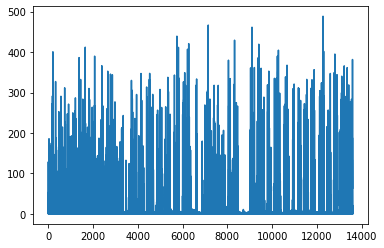

In [415]:
plt.plot(fictrac['R'])

In [416]:
dims = {'x':brain.shape[0],
        'y':brain.shape[1],
        'z':brain.shape[2],
        't':brain.shape[3]}

In [417]:
neural_activity = brain.reshape(-1, dims['t'])

In [418]:
neural_activity.shape

(68265, 13600)

In [419]:
corrs = {}
for behavior in ['R','L','F']:
    corrs_ = []
    for v in range(neural_activity.shape[0]):
        corr = scipy.stats.pearsonr(fictrac[behavior], neural_activity[v,:])[0]
        corrs_.append(corr)
    corrs_ = np.reshape(corrs_,(dims['x'],dims['y'],dims['z']))
    corrs[behavior] = corrs_

Text(0.5, 1.0, 'F, vmax=0.05')

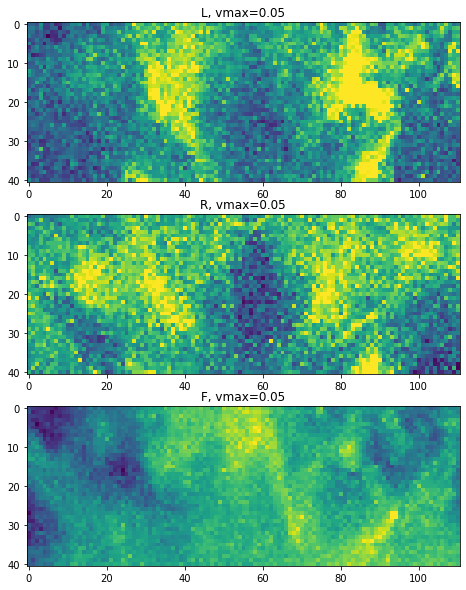

In [420]:
vmax = 0.05

plt.figure(figsize=(10,10))
plt.subplot(311)
plt.imshow(np.max(corrs['L'],axis=2).T,vmax=vmax)
plt.title(F'L, vmax={vmax}')

plt.subplot(312)
plt.imshow(np.max(corrs['R'],axis=2).T,vmax=vmax)
plt.title(F'R, vmax={vmax}')

plt.subplot(313)
plt.imshow(np.max(corrs['F'],axis=2).T,vmax=vmax)
plt.title(F'F, vmax={vmax}')

# Warp IPS corr

In [109]:
corr_3var = np.concatenate((corrs['R'][...,np.newaxis],corrs['L'][...,np.newaxis],corrs['F'][...,np.newaxis]),axis=3)
corr_3var.shape

(111, 41, 15, 3)

In [110]:
corr_3var = ants.from_numpy(corr_3var)
corr_3var.set_spacing((2.6,2.6,5,1))

In [111]:
corr_3var = ants.resample_image(corr_3var,(380,140,93,3),use_voxels=True)
ants.set_direction(corr_3var,np.eye(4))

In [112]:
corr_3var

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (380, 140, 93, 3)
	 Spacing    : (0.7546, 0.7482, 0.7609, 1.0)
	 Origin     : (0.0, 0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

In [113]:
IPS_CORR_in_FDA = ants.apply_transforms(fixed = FDA_lowres_crop,
                                        moving = corr_3var,
                                        transformlist = IPS_2_FDA['fwdtransforms'],
                                        imagetype=3)

In [114]:
IPS_CORR_in_FDA

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (380, 140, 92, 3)
	 Spacing    : (0.76, 0.76, 0.76, 1.0)
	 Origin     : (0.0, 0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

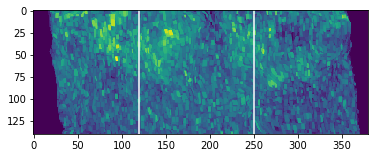

In [137]:
plt.imshow(np.max(IPS_CORR_in_FDA[:,:,:,2],axis=2).T)
plt.axvline(120,color='w')
plt.axvline(250,color='w')

# Crop to same area of FDA

In [138]:
beh = 2
OG_corr_crop = OG_corr[beh][center['x']-sub_mids['x']:center['x']+sub_mids['x'],
                             center['y']-sub_mids['y']:center['y']+sub_mids['y'],
                             center['z']-sub_mids['z']:center['z']+sub_mids['z']]

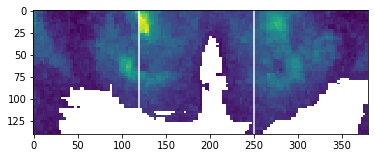

In [139]:
plt.imshow(np.max(OG_corr_crop,axis=2).T)
plt.axvline(120,color='w')
plt.axvline(250,color='w')